In [16]:
import sys
sys.argv = ['']
sys.path.append("../..")

from src.grid_world import GridWorld
import numpy as np
import random
from tqdm import tqdm

In [18]:
class MonteCarloEpsilonGreedy:
    def __init__(self, env, epsilon=0.1, gamma=0.9, num_episodes=5000, episode_length=100):
        # Environment parameters
        self.env = env
        self.num_states = env.num_states
        self.num_actions = len(env.action_space)

        # Agent parameters
        self.num_episodes = num_episodes
        self.episode_length = episode_length
        self.action_space = env.action_space
        self.epsilon = epsilon
        self.gamma = gamma

        self.Q = np.zeros((self.num_states, self.num_actions))
        self.V = np.zeros(self.num_states)
        # 初始化均匀随机策略
        self.policy = np.ones((self.num_states, self.num_actions)) / self.num_actions

        self.Return = np.zeros((self.num_states, self.num_actions))
        self.Number = np.zeros((self.num_states, self.num_actions))

    def state2idx(self, state):
        """修复状态索引映射错误：x是列，y是行，正确的索引计算应该是 y * 列数 + x"""
        x, y = state  # state是(x,y)坐标
        return y * self.env.env_size[0] + x  # 原代码颠倒了x和y的计算逻辑

    def idx2state(self, idx):
        """对应修复索引转状态的逻辑"""
        cols = self.env.env_size[0]
        y = idx // cols
        x = idx % cols
        return x, y

    def action2idx(self, action):
        return self.action_space.index(action)

    def idx2action(self, idx):
        return self.action_space[idx]

    def choose_action(self, state_idx):
        """
        Choose an action according to current policy (epsilon-soft)
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            max_value = np.max(self.policy[state_idx])
            best_actions = np.where(self.policy[state_idx] == max_value)[0]  # 原代码错误使用policy，应该用Q值选最优动作
            return np.random.choice(best_actions)

    def generate_episode(self):
        episode = []
        self.env.reset()
        s = self.env.start_state
        a_idx = self.choose_action(self.state2idx(s))
        a = self.idx2action(a_idx)
        for t in range(self.episode_length):
            state, reward, done, info = self.env.step(a)
            episode.append((s, a, reward))
            if done:
                break
            s = state  # 修复：忘记更新当前状态s
            a_idx = self.choose_action(self.state2idx(s))
            a = self.idx2action(a_idx)
        return episode

    def run(self):
        for episode in range(self.num_episodes):
            # 生成一个episode
            episode_data = self.generate_episode()
            G = 0
            T = len(episode_data)
            # 记录已经访问过的(state, action)对，实现首次访问型MC
            visited = set()

            # 从后往前计算回报
            for t in range(T-1, -1, -1):
                s, a, r = episode_data[t]
                s_idx = self.state2idx(s)
                a_idx = self.action2idx(a)

                # 累计回报
                G = self.gamma * G + r

                # 首次访问型MC：只在第一次访问该(state, action)时更新
                if (s_idx, a_idx) not in visited:
                    visited.add((s_idx, a_idx))
                    self.Return[s_idx, a_idx] += G
                    self.Number[s_idx, a_idx] += 1
                    # 策略评估：更新Q值
                    self.Q[s_idx, a_idx] = self.Return[s_idx, a_idx] / self.Number[s_idx, a_idx]

                    # 策略改进：正确的ε-贪心策略更新
                    # 1. 找到当前状态下的最优动作
                    max_q = np.max(self.Q[s_idx])
                    best_actions = np.where(self.Q[s_idx] == max_q)[0]
                    num_best_actions = len(best_actions)

                    # 2. 初始化策略概率
                    self.policy[s_idx] = self.epsilon / self.num_actions  # 所有动作先分配ε/|A|

                    # 3. 给最优动作分配(1-ε)/|最优动作数|的概率
                    for action_idx in best_actions:
                        self.policy[s_idx, action_idx] += (1 - self.epsilon) / num_best_actions

            if (episode + 1) % 500 == 0:  # 每500个episode打印一次，减少输出
                print(f"Episode {episode + 1} completed.")

    def get_policy(self):
        return self.policy

    def get_Q(self):
        return self.Q

    def get_V(self):
        for s_idx in range(self.num_states):
            self.V[s_idx] = np.max(self.Q[s_idx])
        return self.V

    def get_deterministic_policy(self):
        deterministic_policy = np.zeros_like(self.policy)
        for s_idx in range(self.num_states):
            max_q = np.max(self.Q[s_idx])
            best_actions = np.where(self.Q[s_idx] == max_q)[0]
            # 随机选一个最优动作（如果有多个）
            best_action = np.random.choice(best_actions)
            deterministic_policy[s_idx, best_action] = 1.0  # 最优动作概率为1，其余为0
        return deterministic_policy

    def render_static(self):
        self.env.render_static(policy=self.get_deterministic_policy(), values=self.get_V())


Episode 500 completed.
Episode 1000 completed.
Episode 1500 completed.
Episode 2000 completed.
Episode 2500 completed.
Episode 3000 completed.
Episode 3500 completed.
Episode 4000 completed.
Episode 4500 completed.
Episode 5000 completed.


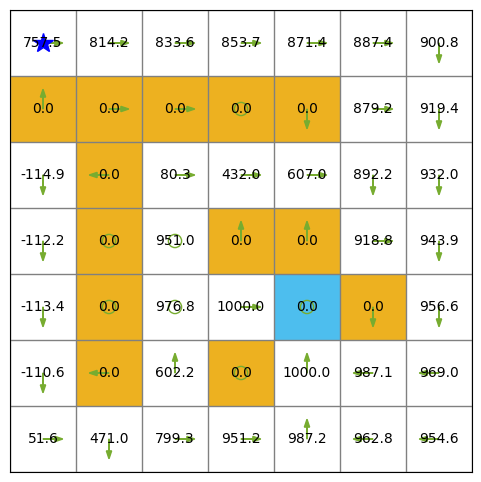

Final Policy:
[[0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.04 0.04 0.04 0.04 0.84]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.04 0.04 0.04 0.04 0.84]
 [0.04 0.84 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84

In [19]:
env = GridWorld()
env.reward_step = 0
env.reward_target = 1000
agent = MonteCarloEpsilonGreedy(env, epsilon=0.2, gamma=0.99, num_episodes=5000, episode_length=1000)
agent.run()
agent.render_static()
print("Final Policy:")
print(agent.get_policy())
